In [39]:
import pandas as pd
import numpy as np
import pyreadr
from datetime import datetime
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
file_path = "/Users/yaolangzhong/Nottingham_Replication/original_code/"

In [19]:
## measures from Bloomberg
bb = pyreadr.read_r(file_path + "data/bloomberg_uncertainty.RData")["data"]
bb.rename(columns={'USSN011': 'SWIV'}, inplace=True)
bb.sort_values(by='date', inplace=True)
for col in ['SWIV', 'SRVIX', 'MOVE']:
    bb[col] = bb[col].astype(np.float64)
    bb[col] = bb[col] / 100

In [20]:
# Load mpu data
mpu = pyreadr.read_r(file_path + "data/mpu10.RData")["mpu10"]
mpu = mpu.rename(columns={"mpu10": "mpu", "bpvol10": "bpvol", "normal10": "normal"})
mpu = mpu.drop(columns=["f10", "normal"])
for col in ['mpu', 'bpvol']:
    mpu[col] = mpu[col].astype(np.float64)

In [21]:
# Load Bundick's data
bun = pd.read_csv("data/bundick.csv")
bun["date"] = pd.to_datetime(bun[["year", "month", "day"]])
bun = bun[["date", "edx4q"]]
bun['edx4q'] = bun['edx4q'].astype(np.float64)

In [22]:
# Load Swanson's data
swan = pd.read_csv("data/swanson.txt", sep="\t", header=None)
swan.columns = ["V1", "V2", "V3", "V4"]
swan["date"] = pd.to_datetime(swan["V1"], format="%Y  %m  %d")
swan[['V2', 'V3', 'V4']] = swan[['V2', 'V3', 'V4']].astype(np.float64)
swan["swan"] = swan["V4"] - swan["V2"]
swan = swan.dropna(subset=["date", "swan"])
swan = swan[["date", "swan"]]

In [23]:
# Load TIV data
tiv = pd.read_csv("data/tiv.csv", na_values="#N/A")
tiv["date"] = pd.to_datetime(tiv["Date"], format="%m/%d/%Y")
tiv = tiv.rename(columns={"TIV_10y": "TIV"})
tiv = tiv[["date", "TIV"]]

In [24]:
# Combine all the data
for df in [mpu, bun, swan, bb, tiv]:
    df['date'] = pd.to_datetime(df['date'])
data = pd.merge(mpu, bun, on="date", how="left")
data = pd.merge(data, swan, on="date", how="left")
data = pd.merge(data, bb, on="date", how="left")
data = pd.merge(data, tiv, on="date", how="left")

In [25]:
# Combine TIV and TYVIX
correlation_all_days = data[["TIV", "TYVIX"]].dropna().corr().iloc[0, 1]
correlation_after_2016 = data[data["date"] >= pd.to_datetime("2016-01-20")][["TIV", "TYVIX"]].dropna().corr().iloc[0, 1]
data["TIV"] = data[["TIV", "TYVIX"]].mean(axis=1)
data = data.drop(columns="TYVIX")

In [26]:
# FOMC announcement days
fomc = pd.read_csv("data/fomc_tight.csv")
fomc.rename(columns={'Date': 'date'}, inplace=True)
fomc['date'] = fomc['date'].replace("3/15/2020", "3/16/2020")
fomc["date"] = pd.to_datetime(fomc["date"], format="%m/%d/%Y")
fomc = fomc[['date']].assign(fomc=1)

In [27]:
## summary stats for appendix
## E(u), var(u), E(du), var(du), starts, ends, nobs
nms = data.columns[1:]
nms_long = ["SRU", "BP vol", "Bundick", "Swanson", "Swaption IV", "SRVIX", "MOVE", "TIV/TYVIX"]
changes = data.copy()
for column in nms:
    changes[column] = changes[column].diff()
changes = pd.merge(changes, fomc, on='date', how='left')
changes['fomc'] = changes['fomc'].replace(np.nan, 0)


In [28]:
# Calculate mean across all columns in `nms` with NA values ignored
mean_row = pd.DataFrame(data[nms].mean(skipna=True)).transpose()
# Calculate standard deviation across all columns in `nms` with NA values ignored
std_dev_data = pd.DataFrame(data[nms].std(skipna=True)).transpose()
# Calculate standard deviation across all columns in `changes` with NA values ignored
std_dev_changes = pd.DataFrame(changes[nms].std(skipna=True)).transpose()
# Count non-NA values across all columns in `nms`
count_non_na = pd.DataFrame(data[nms].count()).transpose()
# Concatenate all the rows
tbl = pd.concat([mean_row, std_dev_data, std_dev_changes, count_non_na])
tbl = tbl.transpose()

In [29]:
# Rename the columns
tbl.columns = ["Elev", "SDlev", "SDch", "nobs"]

# Add 'name' and 'long' columns
tbl['name'] = nms
tbl['long'] = nms_long

# Define function to format date
def formdate(d):
    return f"{d.month:02d}/{d.year}"

# Create 'starts', 'ends', and 'period' columns
tbl['starts'] = [data.loc[data[nm].notna(), 'date'].min().strftime('%Y-%m-%d') for nm in nms]
tbl['ends'] = [data.loc[data[nm].notna(), 'date'].max().strftime('%Y-%m-%d') for nm in nms]
tbl['period'] = [f"{formdate(data.loc[data[nm].notna(), 'date'].min())}-{formdate(data.loc[data[nm].notna(), 'date'].max())}" for nm in nms]

# Create 'cor.mpu' and 'cor.dmpu' columns
tbl['cor.mpu'] = [pearsonr(data['mpu'][data['mpu'].notna() & data[nm].notna()], 
                           data[nm][data['mpu'].notna() & data[nm].notna()])[0] for nm in nms]
tbl['cor.dmpu'] = [pearsonr(changes['mpu'][changes['mpu'].notna() & changes[nm].notna()], 
                            changes[nm][changes['mpu'].notna() & changes[nm].notna()])[0] for nm in nms]

# Rearrange and print the columns
tbl = tbl[['name', 'long', 'Elev', 'SDlev', 'SDch', 'cor.mpu', 'cor.dmpu', 'period', 'nobs']]
# Remove the 'name' column
tbl = tbl.drop(columns=['name'])
tbl.reset_index(drop=True, inplace=True)
print(tbl)

          long      Elev     SDlev      SDch   cor.mpu  cor.dmpu  \
0          SRU  0.902351  0.340956  0.022706  1.000000  1.000000   
1       BP vol  0.857872  0.352310  0.027273  0.994541  0.860556   
2      Bundick  1.167026  0.259472  0.036334  0.969222  0.687861   
3      Swanson  1.420340  0.520403  0.139362  0.907944  0.339376   
4  Swaption IV  0.706465  0.308339  0.023396  0.964284  0.688179   
5        SRVIX  0.802803  0.101671  0.008383  0.045067  0.394790   
6         MOVE  0.921188  0.275287  0.039896  0.765970  0.438227   
7    TIV/TYVIX  6.715401  1.882945  0.518751  0.668669  0.211140   

            period    nobs  
0  01/1990-09/2020  7756.0  
1  01/1990-09/2020  7756.0  
2  01/1994-12/2008  3782.0  
3  10/1995-12/2012  4337.0  
4  05/2005-09/2020  3764.0  
5  06/2012-09/2020  2068.0  
6  01/1990-09/2020  7751.0  
7  01/1990-05/2020  7598.0  


In [30]:
print("Correlations of changes on all days:")
corrs_all_days = [pearsonr(changes['mpu'][changes['mpu'].notna() & changes[nm].notna()], 
                           changes[nm][changes['mpu'].notna() & changes[nm].notna()])[0] for nm in nms]
print(np.round(corrs_all_days, 3))

print("Correlations of changes on FOMC days only:")
corrs_fomc_days = [pearsonr(changes.loc[changes['fomc'] == 1, 'mpu'][changes['mpu'].notna() & changes[nm].notna()],
                            changes.loc[changes['fomc'] == 1, nm][changes['mpu'].notna() & changes[nm].notna()])[0] for nm in nms]
print(np.round(corrs_fomc_days, 3))

tbl.to_latex(index=False, float_format="%.3f", buf="output/table_1.tex")

Correlations of changes on all days:
[1.    0.861 0.688 0.339 0.688 0.395 0.438 0.211]
Correlations of changes on FOMC days only:
[1.    0.902 0.905 0.329 0.781 0.513 0.47  0.207]


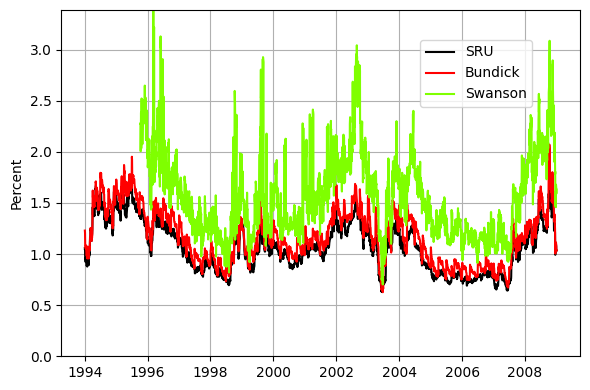

In [38]:

# Select and rename columns
pdat = data[['date', 'mpu', 'edx4q', 'swan']].copy()
pdat.columns = ['date', 'SRU', 'Bundick', 'Swanson']
# Filter dates
pdat = pdat[(pdat['date'].dt.year >= 1994) & (pdat['date'].dt.year <= 2008)]
# Melt the DataFrame to long format
pdat = pdat.melt(id_vars='date', var_name='series', value_name='y')
# Define the color mapping, replace 'chartreuse4' with 'chartreuse'
color_mapping = {'SRU': 'black', 'Bundick': 'red', 'Swanson': 'chartreuse'}
# Plot the data
plt.figure(figsize=(6, 4))
sns.lineplot(data=pdat, x='date', y='y', hue='series', palette=color_mapping)
# Set the y-axis limit
plt.ylim(0, pdat['y'].max())
# Remove the x-axis label, and set the y-axis label
plt.xlabel('')
plt.ylabel('Percent')
# Move the legend
plt.legend(bbox_to_anchor=(0.8, 0.7))
# Save the figure
plt.tight_layout()
plt.grid()
plt.savefig('output/figure_A2.pdf')